# Network-Assisted TCP Congestion Control Simulation
### EEE4121F Project B
### By Shahil Poonsamy, PNSSHA003, 13 June 2021

## Introduction
This notebook investigates the performance of a network-assisted congestion control protocol against common TCP congestion control algorithms as an alternative to network emulation. This protocol is called TCP Tactile for the intents of this investigation, as it receives a 'physical sense' of the network. TCP Tactile includes a modified TCP header which contains aggregate router congestion information and other control features; however, only the congestion information contain in the data payload headers will be considered here (i.e. the network will not be considered to be sending any other messages besides application layer data, including handshaking and "slow-down" messages)

## Simulating a simple network
The initial set up parameters of this network is derived from the bufferbloat example in the mininet tutorial (https://github.com/mininet/mininet/wiki/Bufferbloat).

For this scenario consider a 2 hosts connected to the same router. The first host is sending over a fast link to the router, which is forwarding to a second host over a slow link, creating a bottleneck. The TCP Reno congestion control protocol is assumed and modelled here. Note that the only loss events that will occur are effectively triple duplicate acks, no timeouts, and that loss occurs 'immediately' as a router buffer is overflowed

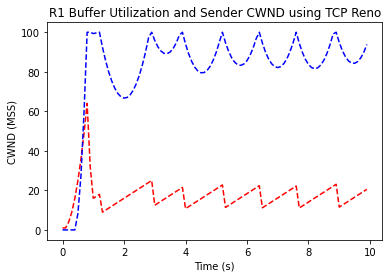

In [184]:
# imports
import matplotlib.pyplot as plt
import numpy as np

# network parameters
h1_bw= 1000000000 #1Gbps - this is effectively assumed 'infinite'
h2_bw = 2000000 #2Mbps - this will cause a bottleneck
r1_capacity = 100 #pkts
rtt = 0.1 #100ms
mss = 1500 #Bytes - normally would be 1460 to compensate for ethernet header
r1_out_rate = 2000000*rtt/(mss*8) #How many packets leave the buffer every RTT

# simulation parameters
tmax = 10 #10s duration
td = 0.1 #100ms resolution, matched with RTT so each sample is 1 RTT

t = np.arange(0, tmax, td)

h1_cwnd = np.zeros(int(tmax/td)) #h1 cwnd
r1_buffer = np.zeros(int(tmax/td)) #r1 buffer

# initial parameters
h1_cwnd[0] = 1 
overflow = False
linear = False

# iteration for each RTT - start at 1
for i in range(1,len(t)):
    
    # calculate window size based on previous information
    if(overflow):
        h1_cwnd[i] = h1_cwnd[i-1]/2
        linear = True;
    elif(not overflow and linear):
        h1_cwnd[i] = h1_cwnd[i-1] + 1
    else:
        h1_cwnd[i] = i**2
    
    # increment buffer by cwnd
    r1_buffer[i] = r1_buffer[i-1] + h1_cwnd[i]
    
    # decrement buffer by slow bandwidth output
    r1_buffer[i] = max(r1_buffer[i] - r1_out_rate, 0)
    
    # check for overflow
    if(r1_buffer[i] > r1_capacity):
        overflow = True
        r1_buffer[i] = r1_capacity
    elif(overflow and r1_buffer[i] < r1_capacity):
        overflow = False

plt.plot(t,h1_cwnd, 'r--', t, r1_buffer, 'b--')
plt.ylabel('CWND (MSS)')
plt.xlabel('Time (s)')
plt.title('R1 Buffer Utilization and Sender CWND using TCP Reno')
plt.show()

## Extending the simulation

It's been shown that a router buffer (and subsequently a sender's cwnd) can be modelled through 4 specific steps:
1. Calculate the window size based on previous information
2. For each router, increment the buffer by the total input cwnd
3. For each router, decrement the buffer by the outfill rate
4. Set tags (overflow, buffer nearly full, buffer empty, etc.)

Based on this, the simulation can be extended to allow for more router or host connections. The buffer sizes of routers as well as link speeds and simulation durations can also be extended to match other scenarios.

Let's modify the size of this buffer to approximate a more real-world scenario highlighting the problems with TCP Reno - the slow start can take far too long for short-lived connections. To do this, we increase the buffer size and the output link speed (reducing the bottleneck). Additionally, the monitored time was increased to 30s

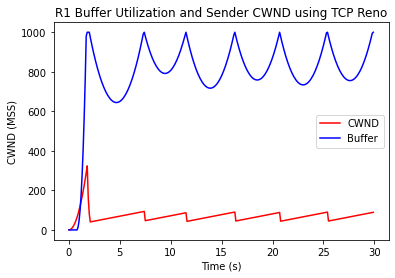

In [208]:
# =============================== network parameters ====================================
# These paramets are meant to simulate network conditions
h1_bw= 1000000000 #1Gbps - this is effectively assumed 'infinite'
h2_bw = 8000000 #8Mbps - this will cause a slight bottleneck
r1_capacity = 1000 # number of packets (matched to mss)
rtt = 0.1 # 100ms - assumed constant
mss = 1500 #Bytes - normally would be 1460 to compensate for ethernet header
# =====================================================================================

r1_out_rate = h2_bw*rtt/(mss*8) #How many packets leave the buffer every RTT

# simulation parameters
tmax = 30 #duration
td = rtt #100ms resolution, matched with RTT so each sample is 1 RTT

t = np.arange(0, tmax, td)

h1_cwnd = np.zeros(int(tmax/td)) #h1 cwnd
r1_buffer = np.zeros(int(tmax/td)) #r1 buffer

# initial parameters
h1_cwnd[0] = 1 
overflow = False
linear = False

# iteration for each RTT - start at 1
for i in range(1,len(t)):
    
    # calculate window size based on previous information
    if(overflow):
        h1_cwnd[i] = h1_cwnd[i-1]/2
        linear = True;
    elif(not overflow and linear):
        h1_cwnd[i] = h1_cwnd[i-1] + 1
    else:
        h1_cwnd[i] = i**2
    
    # increment buffer by cwnd
    r1_buffer[i] = r1_buffer[i-1] + h1_cwnd[i]
    
    # decrement buffer by slow bandwidth output
    r1_buffer[i] = max(r1_buffer[i] - r1_out_rate, 0)
    
    # check for overflow
    if(r1_buffer[i] > r1_capacity):
        overflow = True
        r1_buffer[i] = r1_capacity
    elif(overflow and r1_buffer[i] < r1_capacity):
        overflow = False

plt.figure()
plt.plot(t,h1_cwnd, 'r', label="CWND")
plt.plot(t, r1_buffer, 'b', label="Buffer")
plt.ylabel('CWND (MSS)')
plt.xlabel('Time (s)')
plt.title('R1 Buffer Utilization and Sender CWND using TCP Reno')
plt.legend()
plt.show()

## Implementing TCP Tactile on a single-router network
The downsides of TCP Reno in this scenario is glaringly obvious - It takes far too long to sense the optimal sending rate once loss occurs, and even before that, during slow start. 
To implement TCP Tactile we need to decide on an optimal buffer capacity. For this example, lets set the target to be 20% of the buffer (not filling the buffer is the best strategy, because as the buffer increases so too does the RTT, but 20% gives some leeway here). Additionally we need to choose a threshold value either side of the target - let's use 10% here. If the sending rate is below the minimum threshold, the router will tell modify the header to tell the sender to match the minimum, and likewise if the send rate is above the maximum, the router will tell the sender to match the minimum. This should keep the sending rate around the target rate.

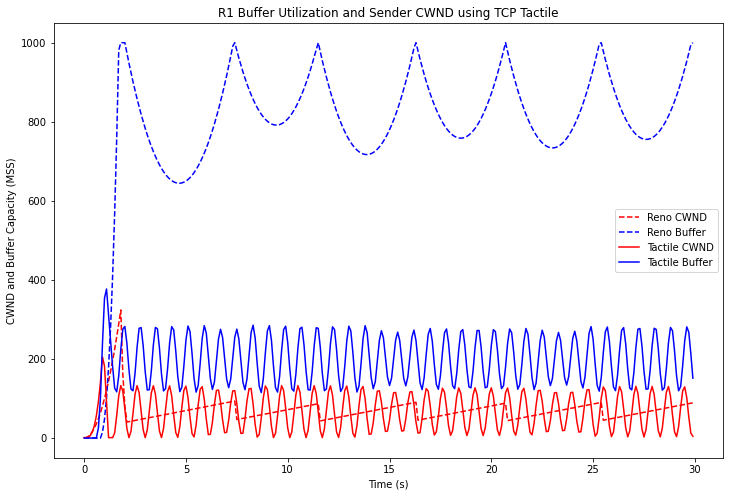

In [209]:
# ================================ tactile parameters ===================================
# These parameters are expected to be set by the sender
target = 0.2 # percentage of buffer capacity
target_fluctuation = 0.01 # value either side of target value to set thresholds
sensitivity = 0.6 # how rapidly change will occur when thresholds are exceeded
# =======================================================================================

min_thresh = target-target_fluctuation
max_thresh = target+target_fluctuation
tac_cwnd = np.zeros(int(tmax/td)) #h1 cwnd using tactile
tac_buffer = np.zeros(int(tmax/td)) #r1 buffer using tactile

# initial parameters
tac_cwnd[0] = 1
count = 0
cwnd_delta = 0

# states
PROBING = 0
SPEED_UP = 1
LINEAR = 2
SLOW_DOWN = 3
OVERFLOW = 4

state = PROBING

# iteration for each RTT - start at 1
for i in range(1,len(t)):
    
    # calculate window size based on previous information
    if(state == PROBING):
        tac_cwnd[i] = tac_cwnd[i-1] + count**2
        count += 1
    elif(state == SPEED_UP):
        tac_cwnd[i] = tac_cwnd[i-1] + cwnd_delta*sensitivity
    elif(state == LINEAR):
        tac_cwnd[i] = tac_cwnd[i-1] + 1
    elif(state == SLOW_DOWN):
        tac_cwnd[i] = max(tac_cwnd[i-1] - cwnd_delta*sensitivity, 1)
    elif(state == OVERFLOW):
        tac_cwnd[i] = tac_cwnd[i-1]/2
    
    
    # increment buffer by cwnd
    tac_buffer[i] = tac_buffer[i-1] + tac_cwnd[i]
    
    # decrement buffer by slow bandwidth output
    tac_buffer[i] = max(tac_buffer[i] - r1_out_rate, 0)
    
    # check status of buffer to calculate next state - router side information
    if(tac_buffer[i] > r1_capacity):
        state = OVERFLOW
        tac_buffer[i] = r1_capacity
    elif(tac_buffer[i] > r1_capacity*max_thresh):
        state = SLOW_DOWN
        cwnd_delta = tac_buffer[i] - r1_capacity*target
    elif(tac_buffer[i] > r1_capacity*min_thresh):
        state = LINEAR
    elif(tac_buffer[i] >= 0 and not state == PROBING):
        state = SPEED_UP
        cwnd_delta = r1_capacity*target - tac_buffer[i]
    else:
        state = PROBING  
    
plt.figure(figsize=(12,8))
plt.plot(t,h1_cwnd, 'r--', label="Reno CWND")
plt.plot(t, r1_buffer, 'b--', label="Reno Buffer")
plt.plot(t, tac_cwnd, 'r', label="Tactile CWND")
plt.plot(t, tac_buffer, 'b', label="Tactile Buffer")
#plt.plot(t, tac_cwnd, 'r--', t, tac_buffer, 'b--')
plt.ylabel('CWND and Buffer Capacity (MSS)')
plt.xlabel('Time (s)')
plt.title('R1 Buffer Utilization and Sender CWND using TCP Tactile')
plt.legend()
plt.show()